In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import pennylane as qml
from pennylane import numpy as np
from functools import reduce
import cirq
from tensorflow import keras
from eqmarl import *

In [14]:
# Check shapes of variational+encoding PQC parameters.
wires = list(range(4))
shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
shape_var, shape_enc

((2, 4, 3), (1, 4, 1))

In [36]:
class Circuit:
    
    def __init__(self,
        wires,
        n_layers,
        ):
        self.wires = wires
        self.n_layers = n_layers

    def __call__(self, weights_var, weights_enc):
        
        VariationalEncodingPQC(
            weights_var=weights_var,
            weights_enc=weights_enc,
            n_layers=self.n_layers,
            wires=self.wires,
            )
        
        return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires]
    
    @property
    def shape(self):
        return self.get_shape(self.wires, self.n_layers)

    @staticmethod
    def get_shape(wires, n_layers):
        return VariationalEncodingPQC.shape(
            n_layers=n_layers,
            wires=wires,
            )

batch_size = 16
n_layers = 1
circuit = Circuit(wires=wires, n_layers=n_layers)

dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

# Assign random circuit parameters.
shape_var, shape_enc = circuit.shape
weights_var = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_var,))
weights_enc = np.random.uniform(low=0., high=np.pi, size=(batch_size, *shape_enc,))

res = qnode(weights_var, weights_enc) # Shape is (n_observables, batch)
res = np.asarray(res) # Reshape to (batch, n_observables)
res.T.shape



# shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)


# qnode(wires, weights_var=weightsvar)

(16, 4)

(<Figure size 1400x500 with 1 Axes>, <Axes: >)

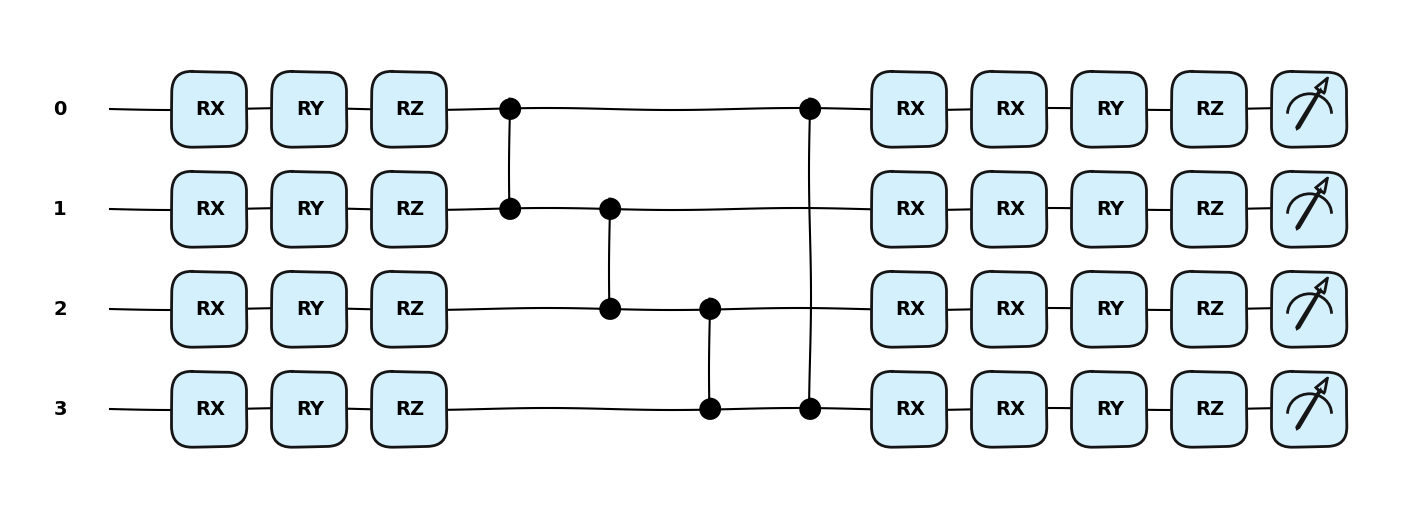

In [39]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2, expansion_strategy='device')(weights_var, weights_enc)

In [205]:
# from pennylane.operation import Operation
# from typing import Sequence, Type
# import itertools
# # class VariationalRotation(Operation):
# #     ops = [qml.RX, qml.RY, qml.RZ]
    
# #     def __init__(self, weights, wires, id=None):
# #         super().__init__(weights, wires=wires, id=id)

# #     @classmethod
# #     def compute_decomposition(cls, weights, wires):
# #         op_list = []
# #         for i, op in enumerate(cls.ops):
# #             op_list.append(op(weights[i], wires=wires))
# #         return op_list

# #     @classmethod
# #     def shape(cls):
# #         return (len(cls.ops),)
    


# # class EncodingLayer(Operation):
# #     """Parameterized encoding layer.
    
# #     Implements `shape()` to determine parameter shapes.
# #     """
# #     operations = [qml.RX]
    
# #     def __init__(self, weights, wires, id=None):
# #         super().__init__(weights, wires=wires, id=id)

# #     @classmethod
# #     def compute_decomposition(cls, 
# #         weights: np.tensor,
# #         wires: list[int|str],
# #         operations: list[Operation] = None,
# #         ):
# #         # Ensure weights have proper shape.
# #         req_shape = cls.shape(wires, operations)
# #         assert weights.numpy().shape == req_shape, f'encoder weights must have shape {req_shape}'
        
# #         # Use default rotations for class instance if none were provided.
# #         if operations is None: 
# #             operations = cls.operations

# #         # Decompose rotations into operations.
# #         op_list = []
# #         for i, wire in enumerate(wires):
# #             for j, op in enumerate(operations):
# #                 op_list.append(op(weights[i, j], wires=wire))

# #         return op_list

# #     @classmethod
# #     def shape(cls, wires: list[int|str], operations: list[Operation] = None):
# #         # Use default operations for class instance if none were provided.
# #         if operations is None: 
# #             operations = cls.operations
        
# #         if isinstance(wires, (int, str)):
# #             wires = [wires]
        
# #         return (len(wires), len(operations),)


# class ParameterizedOperation(Operation):
#     """Performs a list of parameterized operations on each qubit.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations = [] # Default is no operations, which will throw an error; users must override this or provide an operations list at runtime.
    
#     def __init__(self, 
#         weights: np.tensor,
#         wires: list[int|str],
#         id: str = None,
#         operations: list[Operation] = None,
#         ):
#         self._hyperparameters = {"operations": operations or self.operations}
#         super().__init__(weights, wires=wires, id=id)

#     @classmethod
#     def compute_decomposition(cls, 
#         weights: np.tensor,
#         wires: list[int|str],
#         operations: list[Operation] = None,
#         ):
#         # Ensure weights have proper shape.
#         req_shape = cls.shape(wires, operations)
#         assert weights.numpy().shape == req_shape, f'parameters must have shape {req_shape}'
        
#         # Use default rotations for class instance if none were provided.
#         if operations is None: 
#             operations = cls.operations

#         # Decompose rotations into operations.
#         op_list = []
#         for i, wire in enumerate(wires):
#             for j, op in enumerate(operations):
#                 op_list.append(op(weights[i, j], wires=wire))

#         return op_list

#     @classmethod
#     def shape(cls, wires: list[int|str], operations: list[Operation] = None):

#         # Use default operations for class instance if none were provided.
#         if operations is None: 
#             operations = cls.operations
        
#         assert len(operations) > 0, 'at least one operation is required'
        
#         if isinstance(wires, (int, str)):
#             wires = [wires]
        
#         return (len(wires), len(operations),)


# class VariationalRotationLayer(ParameterizedOperation):
#     """Parameterized variational rotation layer.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations = [qml.RX, qml.RY, qml.RZ] # Default is 3 rotation sequence RX, RY, RZ.


# class EncodingLayer(ParameterizedOperation):
#     """Parameterized variational rotation layer.
    
#     Implements `shape()` to determine parameter shapes.
#     """
#     operations = [qml.RX]
    

# def circular_entangling_layer(
#     wires: list[int|str],
#     gate: Operation = qml.CZ,
#     ) -> list[Operation]:
#     """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
#     op_list = []
#     for w0, w1 in zip(wires, wires[1:]):
#         op_list.append(gate(wires=[w0, w1]))
#     if len(wires) != 2:
#         op_list.append(gate(wires=[wires[0], wires[-1]])) # Entangle the first and last qubit.
#     return op_list

# def unpack_operation_to_list(op: Operation | Sequence[Operation]) -> list[Operation]:
#     # Single operation, so return list of size 1.
#     if isinstance(op, Operation):
#         return [op]
#     # Sequence of operations, so convert to list and return.
#     elif hasattr(op, '__iter__'):
#         return list(itertools.chain.from_iterable(unpack_operation_to_list(o) for o in op))
#     # Return operation as-is.
#     else:
#         raise ValueError(f'operation must be one of {{{Operation}, hasattr(__iter__)}} but received {type(op)}')


# class VariationalEncodingPQC(Operation):
#     _hyperparameters = {
#         "variational_layer": VariationalRotationLayer,
#         "encoding_layer": EncodingLayer,
#         "entangling_layer": circular_entangling_layer,
#     }
    
#     def __init__(self,
#         weights_var: np.tensor,
#         weights_enc: np.tensor,
#         n_layers: int,
#         wires: list[int|str],
#         variational_layer: Type[ParameterizedOperation] = None,
#         encoding_layer: Type[ParameterizedOperation] = None,
#         entangling_layer: Type[Operation] = None,
#         id: str = None,
#         ):
#         self._hyperparameters = {
#             "variational_layer": variational_layer or self._hyperparameters["variational_layer"],
#             "encoding_layer": encoding_layer or self._hyperparameters["encoding_layer"],
#             "entangling_layer": entangling_layer or self._hyperparameters["entangling_layer"],
#         }
#         super().__init__(weights_var, weights_enc, n_layers, wires=wires, id=id)

#     @staticmethod
#     def compute_decomposition(
#         weights_var: np.tensor,
#         weights_enc: np.tensor,
#         n_layers: int,
#         wires: list[int|str],
#         variational_layer: Type[ParameterizedOperation],
#         encoding_layer: Type[ParameterizedOperation],
#         entangling_layer: Type[Operation],
#         ):

#         op_list = []
#         for l in range(n_layers):
#             # Variational layer.
#             op_list.extend(unpack_operation_to_list(variational_layer(weights=weights_var[l], wires=wires)))
#             op_list.extend(unpack_operation_to_list(entangling_layer(wires=wires)))
            
#             # Encoding layer.
#             op_list.extend(unpack_operation_to_list(encoding_layer(weights=weights_enc[l], wires=wires)))

#         # Last variational layer at the end.
#         op_list.extend(unpack_operation_to_list(variational_layer(weights=weights_var[l], wires=wires)))

#         return op_list

#     @classmethod
#     def shape(cls,
#         n_layers: int,
#         wires: list[int|str],
#         variational_layer: Type[ParameterizedOperation] = None,
#         encoding_layer: Type[ParameterizedOperation] = None,
#         ):
#         """Returns tuple of (shape_var, shape_enc)."""

#         # Compute shape for single variational layer.
#         shape_var = (variational_layer or cls._hyperparameters["variational_layer"]).shape(wires)

#         # Compute shape for all variational layers.
#         shape_var = (n_layers + 1, *shape_var) # +1 because there is one additional variational layer at the end.

#         # Compute shape for single encoding layer.
#         shape_enc = (encoding_layer or cls._hyperparameters["encoding_layer"]).shape(wires)
        
#         # Compute shape for all encoding layers.
#         shape_enc = (n_layers, *shape_enc)
        
#         return shape_var, shape_enc


from eqmarl.circuits.pqc import *


wires = list(range(3))
dev = qml.device('default.qubit', wires=len(wires))

def circuit(inputs, weights_var, weights_enc):

    # for w in wires:
    #     weights = np.random.random(size=VariationalRotation.shape())
    #     VariationalRotation(weights=weights, wires=w)
    #     VariationalRotation(weights=weights, wires=w)
    
    # shape_enc = EncodingLayer.shape(wires=wires, operations=[qml.RX, qml.RY])
    # weights_enc = np.random.random(size=shape_enc)
    # EncodingLayer(weights_enc, wires, operations=[qml.RX, qml.RY])
    # # EncodingLayer.compute_decomposition(weights_enc, wires, operations=[qml.RX, qml.RY])
    # print(weights_enc)
    
    # shape_var = VariationalRotationLayer.shape(wires=wires)
    # weights_var = np.random.random(size=shape_var)
    # VariationalRotationLayer(weights_var, wires)
    # # EncodingLayer.compute_decomposition(weights_var, wires, operations=[qml.RX, qml.RY])
    # print(weights_var)
    
    # shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
    # weights_var = np.random.random(size=shape_var)
    # weights_enc = np.random.random(size=shape_enc)
    # shape_var, shape_enc
    VariationalEncodingPQC(weights_var=weights_var, weights_enc=weights_enc, n_layers=1, wires=wires)
    # VariationalEncodingPQC.decomposition()
    # op.decomposition()
        
        
    return [qml.expval(qml.PauliZ(wires=w)) for w in wires]

qnode = qml.QNode(func=circuit, device=dev, interface='tf')
# print(qml.draw(qnode, wire_order=wires)(wires))
# # # qnode(range(3))


shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# weights_var = np.random.random(size=shape_var)
# weights_enc = np.random.random(size=shape_enc)

shape_var, shape_enc

# weight_shapes = {
#     'weights_var': shape_var,
#     'weights_enc': shape_enc,
# }
# qlayer = qml.qnn.KerasLayer(qnode=qnode, weight_shapes=weight_shapes, output_dim=len(wires))
# qlayer

# inp = keras.Input(shape=(2,))
# model = keras.Sequential([inp, keras.layers.Dense(2), qlayer, keras.layers.Dense(2, activation='softmax')])
# model.summary()

# # qnode(wires)
# # qnode(wires)

# # qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires)

# # shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# # weights_var = np.random.random(size=shape_var)
# # weights_enc = np.random.random(size=shape_enc)
# # op = VariationalEncodingPQC(weights_var=weights_var, weights_enc=weights_enc, n_layers=1, wires=wires)
# # op = circular_entangling_layer(wires)
# # unpack_operation_to_list([op, 3])
# # hasattr(op, '__iter__')
# # # dev.stopping_condition(op)
# # op.decomposition()

# # shape_var = VariationalRotationLayer.shape(wires=wires)
# # shape_enc = EncodingLayer.shape(wires=wires, operations=[qml.RX, qml.RY])
# # shape_var, shape_enc

# # shape_var, shape_enc = VariationalEncodingPQC.shape(n_layers=1, wires=wires)
# # shape_var, shape_enc

((2, 3, 3), (1, 3, 1))

agents_var_thetas.shape=(3, 2, 2, 4, 3)
agents_enc_inputs.shape=(3, 2, 1, 4)


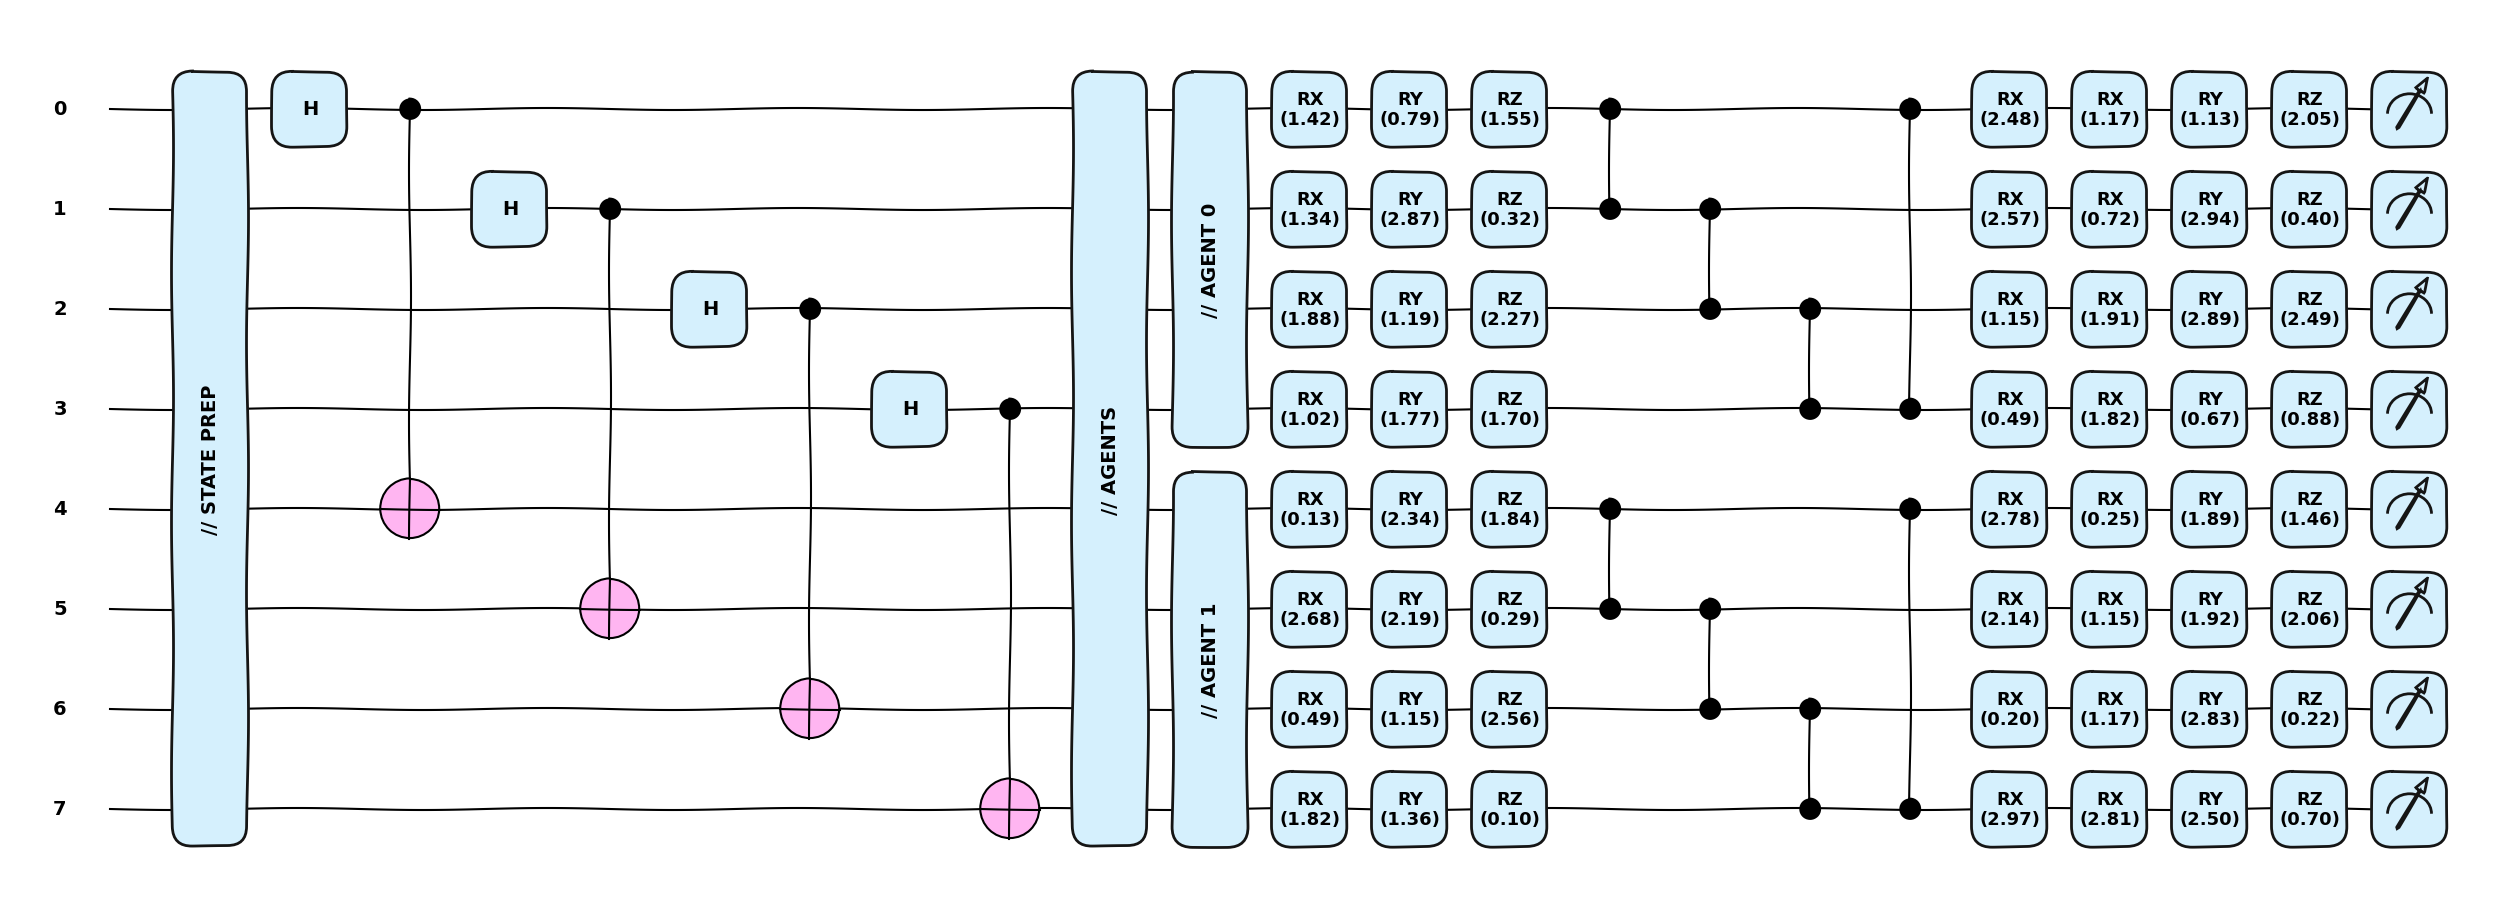

In [136]:
def variational_rotation_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[..., i, 0], wires=wire)
        qml.RY(phi=phi[..., i, 1], wires=wire)
        qml.RZ(phi=phi[..., i, 2], wires=wire)


def circular_entangling_layer(
    wires: list[int],
    ):
    """Entangles a list of qubits with their next-neighbor in circular fashion (i.e., ensures first and last qubit are also entangled)."""
    for w0, w1 in zip(wires, wires[1:]):
        qml.CZ(wires=[w0, w1])
    if len(wires) != 2:
        qml.CZ(wires=[wires[0], wires[-1]]) # Entangle the first and last qubit.


def single_rotation_encoding_layer(
    wires: list[int],
    phi: np.ndarray,
    ):
    for i, wire in enumerate(wires):
        qml.RX(phi=phi[..., i], wires=wire)


def variational_encoding_pqc(
    wires: list[int],
    n_layers: int,
    var_thetas: np.ndarray,
    enc_inputs: np.ndarray,
    ):
    n_var_rotations = 3
    n_wires = len(wires)
    d = n_wires
    
    var_thetas = np.asarray(var_thetas)
    # assert var_thetas.shape == (n_layers+1, d, n_var_rotations), "var_thetas must have shape (n_layers+1, d, n_var_rotations)"
    
    enc_inputs = np.asarray(enc_inputs)
    # assert enc_inputs.shape == (n_layers, d), "enc_inputs must have shape (n_layers, d)"
    
    for l in range(n_layers):
        variational_rotation_layer(wires, var_thetas[..., l, :, :])
        circular_entangling_layer(wires)
        single_rotation_encoding_layer(wires, enc_inputs[..., l, :])
    variational_rotation_layer(wires, var_thetas[..., n_layers, :, :])


## Functions to create various entangled input states.


def entangle_agents_phi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_phi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Phi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def entangle_agents_psi_plus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^+$."""
    for i in range(d):
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])
            

def entangle_agents_psi_minus(wires: list[int], d: int, n: int):
    """Entangles via $\\Psi^-$."""
    for i in range(d):
        qml.PauliX(wires=wires[i])
        qml.Hadamard(wires=wires[i])
        for j in range(n-1):
            qml.PauliX(wires=wires[(j+1)*d + i])
            qml.CNOT(wires=[wires[j*d + i], wires[(j+1)*d + i]])


def TensorPauliZ(wires, n, d) -> list:
    all_obs = []
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
        obs = reduce((lambda a, b: a @ b), ops)
        all_obs.append(obs)
        all_obs.append(-obs)
    return all_obs


def IndividualPauliZ(wires) -> list:
    all_obs = []
    for w in wires:
        obs = qml.PauliZ(w)
        all_obs.append(obs)
    return all_obs



class AnnotationGate(qml.Identity):
    """This gate behaves like the Identity, but allows users to modify the string label of the gate when printed or drawn."""
    
    def __init__(self, annotation: str, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.annotation = annotation
    
    def label(self, decimals=None, base_label=None, cache=None):
        return base_label or self.annotation

# dev = qml.device('default.qubit', wires=len(wires))

# @qml.batch_params
# @qml.qnode(dev)
def circuit(
    wires: list,
    d: int, # qubit dimensions for each agent
    n: int, # number of agents
    n_layers: int,
    agents_var_thetas: np.ndarray,
    agents_enc_inputs: np.ndarray,
    initial_state_vector: str|np.ndarray = None,
    obs_func = lambda wires: TensorPauliZ(wires, n, d),
    annotations: bool = False,
    ):
    # n_wires = len(wires)
    
    # for w in wires:
    #     # qml.Hadamard(wires=w)
    #     qml.RX()
    
    # Variational parameters.
    # symbol_superscript_index = None
    n_var_rotations = 3
    
    ########
    agents_var_thetas = np.asarray(agents_var_thetas)
    # assert agents_var_thetas.shape == (n, n_layers+1, d, n_var_rotations), "agents_var_thetas must have shape (n, n_layers+1, d, n_var_rotations)"
    
    agents_enc_inputs = np.asarray(agents_enc_inputs)
    # assert agents_enc_inputs.shape == (n, n_layers, d), "agents_enc_inputs must have shape (n, n_layers, d)"
    ########
    
    # var_thetas = sympy.symbols(f"theta{f'^{{({symbol_superscript_index})}}' if symbol_superscript_index is not None else ''}(0:{n_var_rotations*(n_layers+1)*d})") # Add +1 here because there will be a final variational layer at the end.
    # var_thetas = np.asarray(var_thetas).reshape((n_layers+1, d, n_var_rotations))
    
    
    # for l in range(n_layers):
    #     variational_rotation_layer(wires, var_thetas[l])
    #     circular_entangling_layer(wires)
    #     single_rotation_encoding_layer(wires, enc_inputs[l])
    # variational_rotation_layer(wires, var_thetas[n_layers])
    
    measurements = []
    
    # entangle_agents_phi_plus(wires, d, n)
    
    if annotations: AnnotationGate('// STATE PREP', wires=wires)
    
    # Prepare initial state.
    if isinstance(initial_state_vector, str):
        match initial_state_vector:
            case 'phi+':
                entangle_agents_phi_plus(wires, d, n)
            case 'phi-':
                entangle_agents_phi_minus(wires, d, n)
            case 'psi+':
                entangle_agents_psi_plus(wires, d, n)
            case 'psi-':
                entangle_agents_psi_minus(wires, d, n)

    elif initial_state_vector is not None:
        qml.QubitStateVector(initial_state_vector, wires=wires)

    # qml.operation.Operator(wires=wires, id='mynaem', name='MYNAME')
    
    # Annotate all wires to add visual separation.
    if annotations: AnnotationGate(f'// AGENTS', wires=wires)
    
    for aidx in range(n):
        qidx = aidx * d # Starting qubit index for the specified agent.
        if annotations: AnnotationGate(f'// AGENT {aidx}', wires=wires[qidx:qidx+d])
        variational_encoding_pqc(
            wires[qidx:qidx+d],
            n_layers,
            agents_var_thetas[..., aidx, :, :, :],
            agents_enc_inputs[..., aidx, :, :],
            )
    
    # for aidx in range(n):
    #     qidx = aidx * d # Starting qubit index for the specified agent.
    #     ops = [qml.PauliZ(w) for w in wires[qidx:qidx+d]]
    #     obs = reduce((lambda a, b: a @ b), ops)
    #     measurements.append(qml.expval(obs))
    #     measurements.append(qml.expval(-obs))
    obs = obs_func(wires)
    for o in obs:
        measurements.append(qml.expval(o))
    
    # return qml.expval(obs), qml.expval(-obs), qml.state()
    # return np.asarray(measurements)
    return np.asarray(measurements)
    # return *measurements, qml.state()
    # return qml.expval(qml.PauliZ(0) @ qml.PauliZ(1)), qml.expval(-(qml.PauliZ(0) @ qml.PauliZ(1))), qml.state()
    # return qml.expval(obs), qml.expval(reduce(lambda a, b: a @ b, [qml.PauliX(w) for w in wires])), qml.state()


n = 2
d = 4
wires = list(range(n * d))

n_layers = 1
batch_size=3
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers, d))
print(f"{agents_var_thetas.shape=}")
print(f"{agents_enc_inputs.shape=}")

# qnode = circuit

dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)
qnode = qml.batch_params(qnode) # Enable batched inputs (first dimension of parameters indicates batches).
# qnode = qml.batch_input(qnode, argnum=0)

fig, ax = qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector='phi+', annotations=True)
# print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ))

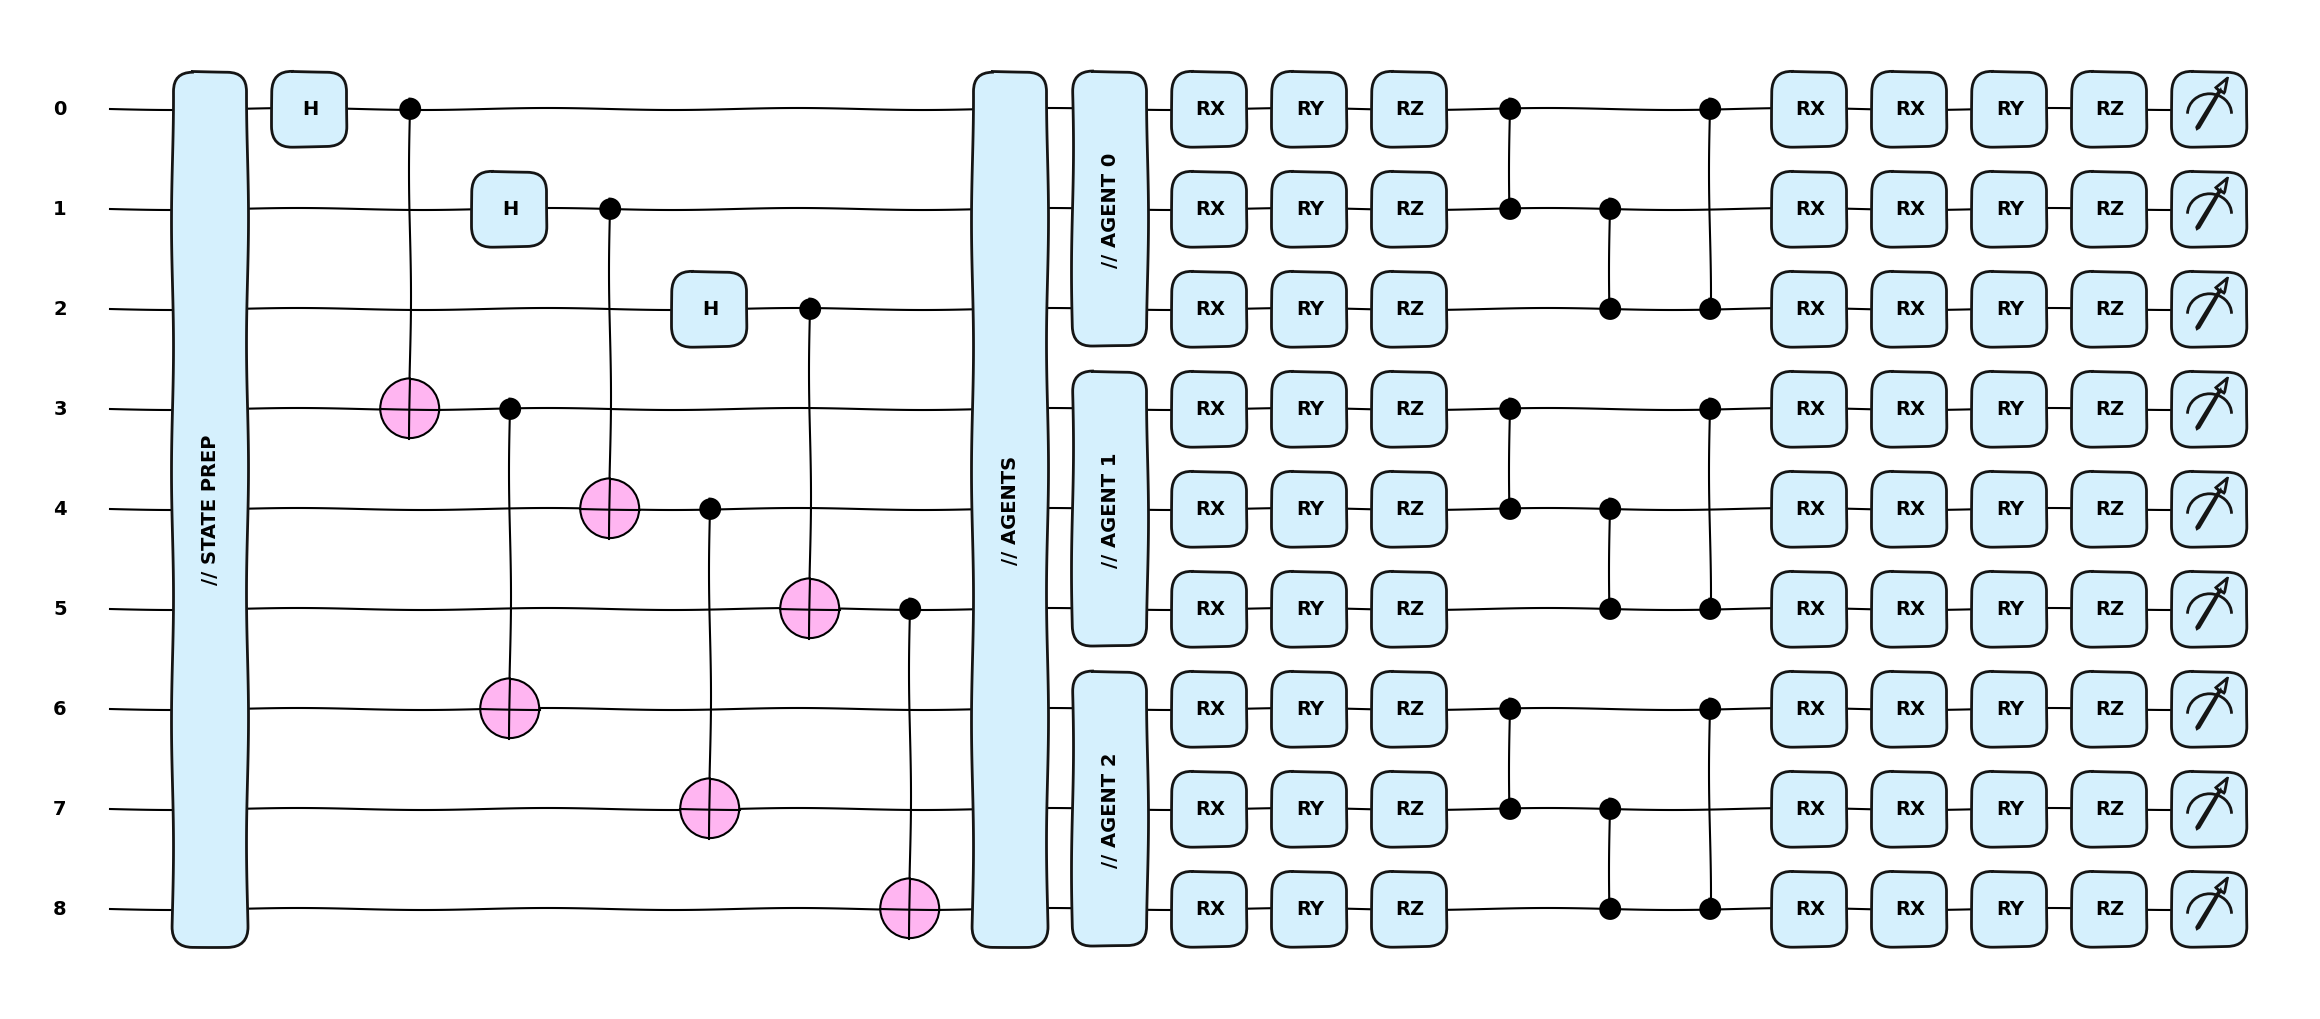

In [137]:
n = 3
d = 3
wires = list(range(n * d))

batch_size = 4
n_layers = 1
agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers+1, d, 3))
agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers, d))


dev = qml.device('default.qubit', wires=len(wires))
qnode = qml.QNode(func=circuit, device=dev)

fig, ax = qml.draw_mpl(qnode, wire_order=wires, style="pennylane", decimals=2)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector='phi+', annotations=True)

In [138]:
print(qml.draw(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ, initial_state_vector='phi+', annotations=True))

0: ─╭// STATE PREP──H─╭●────────────────╭// AGENTS─╭// AGENT 0──RX(M0)──RY(M9)───RZ(M18)─╭●────╭●
1: ─├// STATE PREP────│───H─╭●──────────├// AGENTS─├// AGENT 0──RX(M1)──RY(M10)──RZ(M19)─╰Z─╭●─│─
2: ─├// STATE PREP────│─────│───H─╭●────├// AGENTS─╰// AGENT 0──RX(M2)──RY(M11)──RZ(M20)────╰Z─╰Z
3: ─├// STATE PREP────╰X─╭●─│─────│─────├// AGENTS─╭// AGENT 1──RX(M3)──RY(M12)──RZ(M21)─╭●────╭●
4: ─├// STATE PREP───────│──╰X─╭●─│─────├// AGENTS─├// AGENT 1──RX(M4)──RY(M13)──RZ(M22)─╰Z─╭●─│─
5: ─├// STATE PREP───────│─────│──╰X─╭●─├// AGENTS─╰// AGENT 1──RX(M5)──RY(M14)──RZ(M23)────╰Z─╰Z
6: ─├// STATE PREP───────╰X────│─────│──├// AGENTS─╭// AGENT 2──RX(M6)──RY(M15)──RZ(M24)─╭●────╭●
7: ─├// STATE PREP─────────────╰X────│──├// AGENTS─├// AGENT 2──RX(M7)──RY(M16)──RZ(M25)─╰Z─╭●─│─
8: ─╰// STATE PREP───────────────────╰X─╰// AGENTS─╰// AGENT 2──RX(M8)──RY(M17)──RZ(M26)────╰Z─╰Z

───RX(M27)──RX(M36)──RY(M45)──RZ(M54)─┤  <Z>
───RX(M28)──RX(M37)──RY(M46)──RZ(M55)─┤  <Z>
───RX(M29)──RX(M38)──RY(M47

In [139]:
def softmax(x, axis=None):
    x = x - np.max(x, axis=axis, keepdims=True)
    y = np.exp(x)
    # print(x.shape)
    # return np.exp(x)/np.sum(np.exp(x), axis=axis)
    return y / np.sum(y, axis=axis, keepdims=True)

In [140]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, obs_func=IndividualPauliZ)
meas = meas.reshape((-1, n, d)) # Reshape to 2D with (n_agents, d_qubits) because each agent only has 1 observation per qubit.

meas.shape, meas, np.asarray(meas >= 0, dtype=int)

((4, 3, 3),
 tensor([[[ 0.03902515,  0.53630104, -0.10160124],
          [-0.36075221, -0.01359086, -0.62174339],
          [ 0.24790921,  0.144741  ,  0.08099148]],
 
         [[-0.26808614,  0.07473084,  0.15757684],
          [-0.05509753,  0.21298678, -0.00092993],
          [-0.36284794, -0.15839511,  0.01014241]],
 
         [[ 0.35265697,  0.14023894, -0.10262498],
          [ 0.039109  , -0.03763832, -0.68525447],
          [ 0.0315339 ,  0.00309345, -0.07013347]],
 
         [[ 0.00400342,  0.1102399 , -0.41521415],
          [ 0.34666249,  0.1633783 ,  0.07035666],
          [ 0.16109609, -0.54024919, -0.59440562]]], requires_grad=True),
 tensor([[[1, 1, 0],
          [0, 0, 0],
          [1, 1, 1]],
 
         [[0, 1, 1],
          [0, 1, 0],
          [0, 0, 1]],
 
         [[1, 1, 0],
          [1, 0, 0],
          [1, 1, 0]],
 
         [[1, 1, 0],
          [1, 1, 1],
          [1, 0, 0]]], requires_grad=True))

In [141]:
softmax([0.19463238,  0.35322998])

tensor([0.4604335, 0.5395665], requires_grad=True)

In [142]:
softmax([[0.19463238,  0.35322998], [0.19463238,  0.35322998]], axis=-1)

tensor([[0.4604335, 0.5395665],
        [0.4604335, 0.5395665]], requires_grad=True)

In [143]:
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)
meas = meas.reshape((-1, n, 2)) # Reshape to 2D with (n_agents, 2)
# meas = np.asarray(meas)
# np.concatenate(meas).reshape((n, 2))

# meas.shape, meas, softmax(meas)
softmax(meas, axis=-1)

tensor([[[0.34408905, 0.65591095],
         [0.4076912 , 0.5923088 ],
         [0.65591095, 0.34408905]],

        [[0.5923088 , 0.4076912 ],
         [0.44198549, 0.55801451],
         [0.47200445, 0.52799555]],

        [[0.55801451, 0.44198549],
         [0.52799555, 0.47200445],
         [0.56005944, 0.43994056]],

        [[0.68033122, 0.31966878],
         [0.43994056, 0.56005944],
         [0.31966878, 0.68033122]]], requires_grad=True)

In [144]:
# Compute matrix representation for entire circuit.
if len(agents_var_thetas.shape) == 5: # batched
    U = qml.matrix(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas[0], agents_enc_inputs[0])
else: # Not batched.
    U = qml.matrix(qnode, wire_order=wires)(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs)

U.shape # for 8 qubits is (256, 256)

(512, 512)

In [145]:
eig_vals, eig_vects = cirq.unitary_eig(U) # eig_vects is a matrix with eigenvectors as columns.
eig_vects.shape

(512, 512)

In [146]:
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]
initial_state_vector

array([ 1.55186792e-03+7.10715679e-03j,  6.75374518e-03+1.32121624e-02j,
        6.28313620e-03+6.13860416e-03j,  5.86435524e-03+2.19319633e-02j,
       -1.94375289e-02+3.03808726e-03j, -4.85706046e-02+1.44715801e-03j,
        1.19624243e-02-1.18836049e-03j,  2.28225514e-02+2.10377718e-02j,
        1.80277964e-02-2.45929259e-03j,  3.42810595e-02-1.42177867e-02j,
        1.65515313e-02-1.44476809e-02j,  5.58452926e-02-1.02704923e-02j,
        3.71873346e-03+4.90653662e-02j, -6.02722926e-03+1.21385886e-01j,
       -5.89796331e-04-3.00610940e-02j,  5.69799874e-02-5.27289523e-02j,
        5.85359110e-03-9.79553326e-04j,  1.10369365e-02-4.97355182e-03j,
        5.25408353e-03-4.87372906e-03j,  1.81067139e-02-3.89914527e-03j,
        1.69615419e-03+1.59607545e-02j, -7.68510229e-04+3.96364217e-02j,
       -4.88641901e-04-9.79539180e-03j,  1.80581165e-02-1.77536102e-02j,
        1.18039721e-03+1.18258018e-03j,  2.94272102e-03+1.71926047e-03j,
        1.97563885e-03+4.09267134e-04j,  3.85061577

((4, 3, 2),
 tensor([[[-1.22124533e-15, -4.16333634e-15],
          [ 4.55191440e-15,  6.38378239e-16],
          [ 1.22124533e-15,  4.16333634e-15]],
 
         [[-4.55191440e-15, -6.38378239e-16],
          [-2.49593132e-01,  7.08826372e-02],
          [ 2.10616734e-01, -1.97701297e-01]],
 
         [[ 2.49593132e-01, -7.08826372e-02],
          [-2.10616734e-01,  1.97701297e-01],
          [ 1.17356987e-01,  6.16522479e-01]],
 
         [[ 2.93819152e-01,  3.57809345e-02],
          [-1.17356987e-01, -6.16522479e-01],
          [-2.93819152e-01, -3.57809345e-02]]], requires_grad=True),
 tensor([[[0.5       , 0.5       ],
          [0.5       , 0.5       ],
          [0.5       , 0.5       ]],
 
         [[0.5       , 0.5       ],
          [0.4205598 , 0.5794402 ],
          [0.60068451, 0.39931549]],
 
         [[0.5794402 , 0.4205598 ],
          [0.39931549, 0.60068451],
          [0.3777368 , 0.6222632 ]],
 
         [[0.56415398, 0.43584602],
          [0.6222632 , 0.3777368 ],

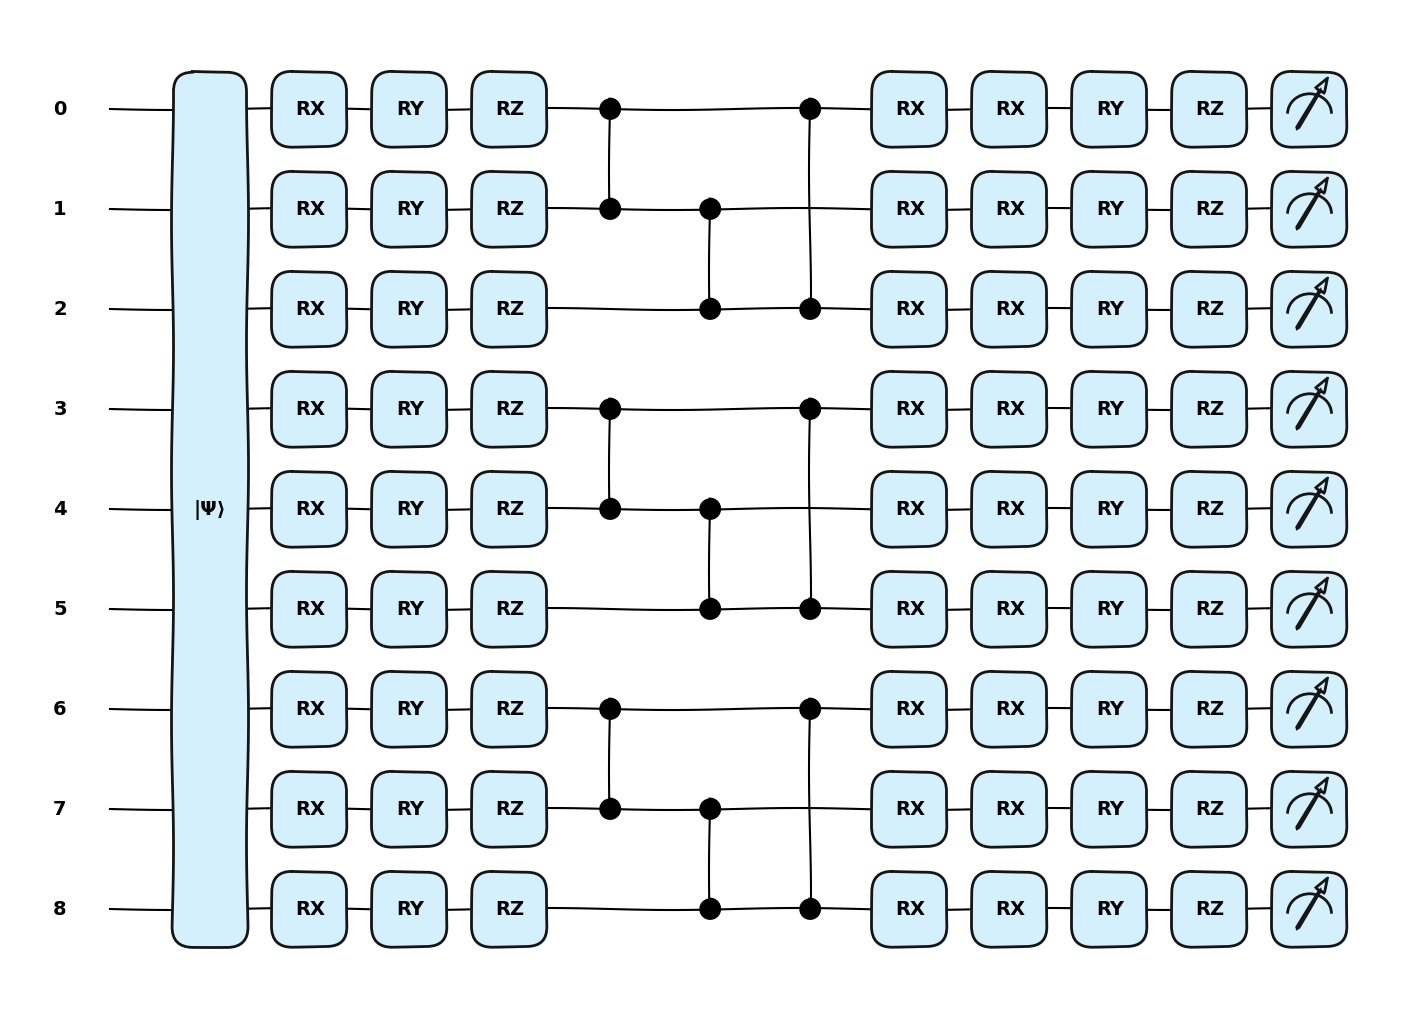

In [147]:
qml.draw_mpl(qnode, wire_order=wires, style="pennylane")(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = qnode(wires, d, n, n_layers, agents_var_thetas, agents_enc_inputs, initial_state_vector)
meas = meas.reshape((-1, n, 2)) # Reshape to 2D with (n_agents, 2)

meas.shape, meas, softmax(meas, axis=-1)

In [148]:
batch_size = 4
tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers+1, d, 3))
tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(batch_size, n, n_layers, d))
meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
meas = meas.reshape((-1, n, 2)) # Reshape to 2D with (n_agents, 2)
meas.shape

(4, 3, 2)

In [149]:
for i in range(0, 100, 32):
    print(i, min(100, i+32-1))

0 31
32 63
64 95
96 100


In [171]:
def experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=100, batch_size=16):
    history = []
    
    # Divide runs into batched chunks.
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector)
        meas = meas.reshape((-1, n, 2)) # Reshape to 3D with (batches, n_agents, 2)

        res = softmax(meas, axis=-1)
        res = np.argmax(res, axis=-1)
        history.extend(res)

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [172]:
# Initial state is all zeros (default |0>).
initial_state_vector = None
experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=100)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([17, 14,  4, 11, 12, 14, 14, 14]))

In [173]:
# Create the desired starting state.
# In this case, an equal superposition of the first and last eigenvector.
initial_state_vector = 1/np.sqrt(2) * eig_vects[:,0] + 1/np.sqrt(2) * eig_vects[:,-1]

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([117, 136, 146, 112, 123, 107, 128, 131]))

In [174]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([122, 119, 129, 115, 124, 146, 129, 116]))

In [175]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([525, 125, 122,  38, 118,  28,  32,  12]))

In [176]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'phi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([515, 121, 130,  35, 122,  37,  36,   4]))

In [177]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi+'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([511, 129, 147,  33, 113,  30,  26,  11]))

In [178]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 'psi-'

experiment(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

(array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1],
        [1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 array([539, 100, 142,  30, 121,  32,  24,  12]))

In [186]:
def experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=100, batch_size=16):
    history = []
    # Divide runs into batched chunks.
    for i in range(0, n_runs, batch_size):
        # Ensure chunk size never causes total number of runs to exceed maximum.
        chunk_size = min(n_runs - i, batch_size)
        tmp_agents_var_thetas = np.random.uniform(low=0., high=np.pi, size=(chunk_size, n, n_layers+1, d, 3))
        tmp_agents_enc_inputs = np.random.uniform(low=0., high=np.pi, size=(chunk_size, n, n_layers, d))
        meas = qnode(wires, d, n, n_layers, tmp_agents_var_thetas, tmp_agents_enc_inputs, initial_state_vector, obs_func=IndividualPauliZ)
        meas = meas.reshape((-1, n, d)) # Reshape to 3D with (batches, n_agents, d_qubits)
        
        history.extend(np.asarray(meas >= 0, dtype=int))

    # Determine how many times each row of actions occurred.
    return np.unique(np.asarray(history), axis=0, return_counts=True)

In [187]:
initial_state_vector = None

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)
states, counts

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 1]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]],
 
        ...,
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 0, 1]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([2, 3, 1, 1, 6, 1, 3, 2, 3, 3, 4, 3, 1, 2, 1, 3, 2, 2, 2, 2, 1, 1,
        2, 2, 5, 2, 3, 1, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 3, 4, 3, 2, 1,
        3, 2, 1, 5, 4, 4, 2, 2, 2, 2, 1, 1, 7, 1, 5, 2, 3, 2, 2, 2, 2, 2,
        1, 3, 1, 1, 2, 1, 4, 1, 1, 6, 3, 2, 2, 1, 1, 3, 1, 4, 2, 2, 1, 1,
        1, 2, 1, 4, 2, 2, 3, 1, 1, 1, 2, 3, 1, 2, 3, 3, 1, 2, 3, 2, 1, 1,
        1, 2, 1, 2, 2, 2, 1, 2, 6, 3, 2, 1, 2, 2, 1, 1, 3, 1, 1, 1, 2, 2,
        3, 2, 5, 3, 7, 2, 2, 3, 1, 3, 1, 2, 5, 5, 1, 3, 1, 7, 1, 4, 1, 4,
        2, 5, 3, 3, 1, 3, 4, 1, 1, 1, 3, 1, 2, 4, 2, 2, 3, 5, 1, 2, 4, 2,
        2, 1, 2

In [190]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 6)

In [191]:
initial_state_vector = 'phi+'

states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

In [193]:
states[0], counts[0]

(array([[0, 0, 0],
        [0, 0, 0],
        [0, 1, 1]]),
 1)

In [192]:
states[-1], counts[-1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]),
 30)

In [194]:
states[-10:]

array([[[1, 1, 1],
        [1, 1, 0],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 0],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [0, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 0, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]])

In [195]:
# Create the desired starting state.
# In this case, an equal superposition of all eigenvectors.
initial_state_vector = 1/np.sqrt(eig_vects.shape[-1]) * np.sum(eig_vects, axis=-1) # Add all columns.
states, counts = experiment_IndividualPauliZ(qnode, d, n, n_layers, initial_state_vector, n_runs=1000, batch_size=32)

In [196]:
counts

array([2, 3, 3, 5, 2, 3, 1, 3, 5, 2, 1, 2, 2, 3, 1, 2, 4, 4, 1, 2, 1, 2,
       2, 3, 1, 1, 4, 3, 2, 2, 2, 1, 3, 3, 2, 3, 4, 2, 1, 1, 4, 3, 2, 1,
       2, 1, 2, 1, 3, 1, 2, 6, 2, 3, 3, 2, 2, 2, 3, 2, 4, 1, 5, 4, 3, 1,
       2, 1, 1, 4, 1, 3, 1, 2, 4, 2, 4, 2, 1, 2, 2, 2, 3, 3, 4, 2, 1, 2,
       1, 1, 1, 2, 2, 2, 1, 1, 4, 4, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 3, 2,
       2, 1, 1, 3, 3, 5, 1, 3, 2, 2, 2, 2, 1, 1, 1, 1, 3, 2, 2, 3, 2, 4,
       1, 6, 2, 1, 2, 1, 2, 4, 3, 1, 3, 2, 3, 2, 1, 1, 3, 2, 2, 2, 1, 2,
       3, 2, 2, 3, 4, 8, 2, 5, 2, 6, 1, 1, 1, 2, 1, 5, 2, 4, 3, 4, 1, 1,
       2, 3, 4, 2, 5, 4, 1, 1, 4, 4, 1, 3, 1, 6, 2, 1, 2, 2, 3, 1, 1, 1,
       3, 1, 1, 3, 3, 2, 1, 4, 1, 4, 1, 2, 2, 1, 4, 2, 3, 2, 3, 1, 2, 2,
       4, 4, 1, 1, 3, 1, 2, 3, 3, 2, 2, 1, 2, 1, 1, 3, 4, 2, 2, 2, 2, 1,
       2, 1, 3, 3, 1, 2, 2, 4, 4, 1, 6, 3, 2, 1, 1, 1, 1, 4, 2, 3, 2, 4,
       2, 3, 3, 3, 1, 2, 2, 2, 5, 3, 1, 2, 2, 5, 3, 2, 1, 5, 4, 1, 4, 3,
       3, 2, 4, 1, 2, 2, 2, 1, 2, 1, 3, 2, 3, 4, 3,

In [199]:
idx = np.all((states[:,0,:] == states[:,1,:]) & (states[:,1,:] == states[:,2,:]), axis=1)
states[idx], counts[idx]

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 1],
         [0, 0, 1],
         [0, 0, 1]],
 
        [[0, 1, 0],
         [0, 1, 0],
         [0, 1, 0]],
 
        [[0, 1, 1],
         [0, 1, 1],
         [0, 1, 1]],
 
        [[1, 0, 0],
         [1, 0, 0],
         [1, 0, 0]],
 
        [[1, 0, 1],
         [1, 0, 1],
         [1, 0, 1]],
 
        [[1, 1, 0],
         [1, 1, 0],
         [1, 1, 0]],
 
        [[1, 1, 1],
         [1, 1, 1],
         [1, 1, 1]]]),
 array([2, 2, 2, 1, 2, 1, 1, 1]))